In [1]:
import pandas as pd
import numpy as np
import random
import string
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer

import collections
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.base import BaseEstimator
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras.layers import Bidirectional
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.callbacks import TensorBoard



tqdm.pandas()
%matplotlib inline

Using TensorFlow backend.


In [7]:
train = pd.read_csv('../../data/nlp_tweet_data/train.csv')
print(train.shape)
print(train.head())


(7613, 5)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [4]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

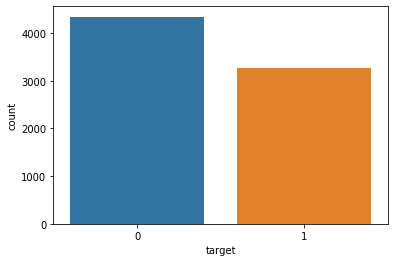

In [5]:
sns.countplot(x='target', data=train)

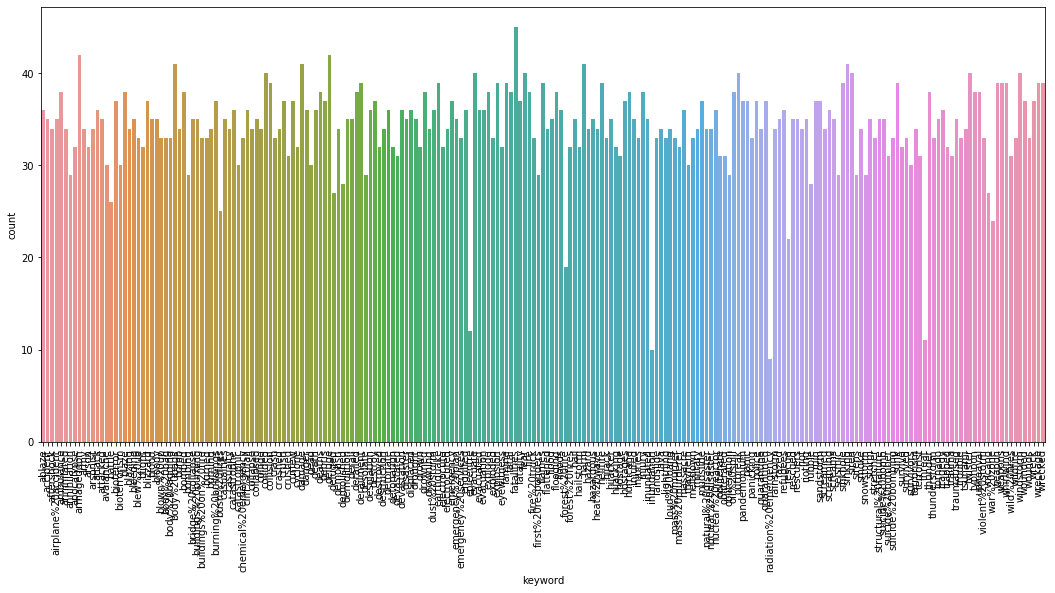

In [6]:
plt.figure(figsize=(18,8))
plt.xticks(rotation=90)
ax = sns.countplot(x='keyword', data=train)

In [10]:
#train = train.drop(['id','keyword','location'],axis=1)

In [9]:
test = pd.read_csv('../../data/nlp_tweet_data/test.csv')
print(test.shape)
print(test.head())

(3263, 4)
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
train['keyword'] = train['keyword'].fillna('')
test['keyword'] = test['keyword'].fillna('')

In [11]:
class_indexes = list(train['target'].value_counts().index)

## Preprocess

In [12]:
 def clean_text(text, remove_stopwords=True, stem_words=False, lemma=True):
    # Clean the text, with the option to remove stopwords and to stem words.

        text = str(text).lower().split()

        # Optionally, remove stop words
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            text = [w for w in text if not w in stops]

        text = " ".join(text)
        
        url = re.compile(r'https?://\S+|www\.\S+')
        text = url.sub(r'',text)

        # Clean the text
        text = re.sub(r"[-()\"#/<>!@&;*:<>{}`'+=~%|.!?,_]", " ", text)
        text = re.sub(r"\]", " ", text)
        text = re.sub(r"\[", " ", text)
        text = re.sub(r"\/", " ", text)
        text = re.sub(r"\\", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"  ", " ", text)
        text = re.sub(r"   ", " ", text)
        text = re.sub(r"   ", " ", text)
        text = re.sub(r"0x00", "", text)
        
        

        # Optionally, shorten words to their stems
        if stem_words:
            text = text.split()
            stemmer = SnowballStemmer('english')
            stemmed_words = [stemmer.stem(word) for word in text]
            text = " ".join(stemmed_words)

        if lemma:
            text = text.split()
            lem = WordNetLemmatizer()
            lemmatized = [lem.lemmatize(word,"v") for word in text]
            text = " ".join(lemmatized)

        # Return a list of words
        return(text)

In [13]:
train['text'] = train['text'].progress_apply(lambda x:clean_text(x))

100%|██████████| 7613/7613 [00:03<00:00, 2478.20it/s]


In [14]:
test['text'] = test['text'].progress_apply(lambda x:clean_text(x))

100%|██████████| 3263/3263 [00:00<00:00, 4774.51it/s]


In [15]:
# label encode the keyword column
le = preprocessing.LabelEncoder()
train['keyword'] = le.fit_transform(train.keyword.values)
test['keyword'] = le.fit_transform(test.keyword.values)

## Generate Features

In [16]:
train_text_lengths = np.array(list(map(len, train.text.str.split(' '))))
test_text_lengths = np.array(list(map(len, test.text.str.split(' '))))

## Count Vectorizer

In [17]:
count_vect = CountVectorizer(ngram_range=(1,2))
count_vect.fit(train['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [18]:
# transform the training and validation data using count vectorizer object
train_count =  count_vect.transform(train['text'])
test_count =  count_vect.transform(test['text'])

In [19]:
count_vect.get_feature_names()

['00',
 '00 11',
 '00 18',
 '00 25',
 '00 52',
 '00 at',
 '00 bestseller',
 '00 cest',
 '00 cs',
 '00 earthquake',
 '00 ep',
 '00 epicenter',
 '00 hiroshima',
 '00 in',
 '00 nnw',
 '00 pm',
 '00 thread',
 '00 thursday',
 '00 tonight',
 '00 white',
 '000',
 '000 gems',
 '000 people',
 '000 riot',
 '0000',
 '0000 utc',
 '00end',
 '00end date',
 '00pm',
 '00pm cdt',
 '01',
 '01 01',
 '01 02',
 '01 04',
 '01 06',
 '01 10',
 '01 11',
 '01 20',
 '01 26',
 '01 50',
 '01 56',
 '01 utc',
 '01 utc2015',
 '02',
 '02 03',
 '02 06',
 '02 15',
 '02 17',
 '02 scene',
 '0215',
 '0215 new',
 '02pm',
 '02pm here',
 '03',
 '03 08',
 '03 58',
 '03 bmw',
 '03 would',
 '030',
 '030 cld',
 '033',
 '033 ignition',
 '034',
 '034 pin',
 '039',
 '039 fire',
 '039 monster',
 '04',
 '04 00',
 '04 01',
 '04 utc',
 '05',
 '05 00pm',
 '05 06',
 '05 08',
 '05 10',
 '05 10pm',
 '05 12pm',
 '05 15',
 '05 15pm',
 '05 16',
 '05 17',
 '05 18',
 '05 2015',
 '05 23',
 '05 28pm',
 '05 29pm',
 '05 31pm',
 '05 33pm',
 '05 45pm'

In [20]:
train_count_df = pd.DataFrame(train_count.todense(), columns=count_vect.get_feature_names())
train_count_df['keyword'] = le.fit_transform(train.keyword.values)

In [21]:
test_count_df = pd.DataFrame(test_count.todense(), columns=count_vect.get_feature_names())
test_count_df['keyword'] = le.fit_transform(test.keyword.values)

In [22]:
train_count_df['text_length'] = list(train_text_lengths)
test_count_df['text_length'] = list(test_text_lengths)

## train test split

In [23]:
x_train, x_test, y_train, y_test = train_test_split(train_count_df, train['target'])
print('train shape: ',x_train.shape)
print('test shape: ',x_test.shape)

train shape:  (5709, 63720)
test shape:  (1904, 63720)


In [28]:
print("train_y label count: ",collections.Counter(y_train))
print("valid_y label count: ",collections.Counter(y_test))

train_y label count:  Counter({0: 3264, 1: 2445})
valid_y label count:  Counter({0: 1078, 1: 826})


## Basic ML models

In [29]:
class MyClassifier(BaseEstimator):

    def __init__(self, classifier_type):
        """
        A Custome BaseEstimator that can switch between classifiers.
        :param classifier_type: string - The switch for different classifiers
        """
        self.classifier_type = classifier_type


    def fit(self, X, y=None):
        if self.classifier_type == 'LDA':
            self.classifier_ = LinearDiscriminantAnalysis(solver='svd')
        elif self.classifier_type == 'Logistic Regression':
            self.classifier_ = LogisticRegression(C=1.0, dual= False, max_iter=500,penalty = 'l2' , 
                                                  solver = 'liblinear', class_weight='balanced', 
                                                  multi_class='ovr', random_state=42, tol=1e-05)
        elif self.classifier_type == 'LinSVC':
            self.classifier_ = svm.LinearSVC(C=1.0, dual= False, fit_intercept=True,
     intercept_scaling =0.1, max_iter=1000,penalty = 'l2' , loss = 'squared_hinge', class_weight='balanced',
     multi_class='ovr', random_state=42, tol=1e-05, verbose=0)
        elif self.classifier_type == 'Random Forest':
            self.classifier_ = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
        elif self.classifier_type == 'Decision Tree':
            self.classifier_ = DecisionTreeClassifier()
        elif self.classifier_type == 'Gradient boost':
            self.classifier_ = GradientBoostingClassifier(n_estimators=50)
        else:
            raise ValueError('Unkown classifier type.')
        self.classifier_.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.classifier_.predict(X)
    

In [30]:
def performance_plots(y_test_sample, y_pred, ml_algo):
    print("---------"+ml_algo+"-----------")
    acc = metrics.accuracy_score(y_pred, y_test_sample)
    print("Accuracy: ",acc)
    print("NORMALISED CM  for Tag6")
    cm = confusion_matrix(y_test_sample,y_pred)
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
    ind = class_indexes
    cols = class_indexes
    cm_df = pd.DataFrame(norm_cm,cols,ind)
    plt.figure(figsize=(22,10)) 
    sns.heatmap(cm_df, annot=True,cmap = "Greens",fmt='g')
    print(classification_report(y_test_sample,y_pred))
    print(accuracy_score(y_test_sample, y_pred))
    return

### LDA

In [34]:
lda_model = MyClassifier('LDA')
lda_model.fit(x_train, y_train)
lda_pred = lda_model.predict(x_test)

---------LDA-----------
Accuracy:  0.6659663865546218
NORMALISED CM  for Tag6
              precision    recall  f1-score   support

           0       0.63      0.97      0.77      1078
           1       0.87      0.27      0.41       826

    accuracy                           0.67      1904
   macro avg       0.75      0.62      0.59      1904
weighted avg       0.74      0.67      0.61      1904

0.6659663865546218


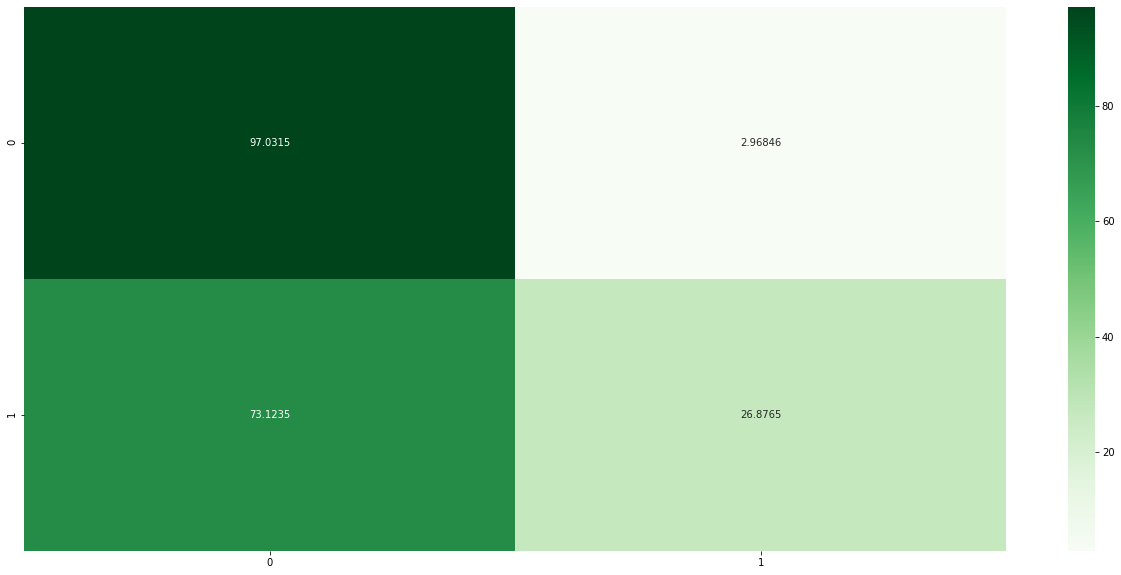

In [35]:
performance_plots(y_test, lda_pred, 'LDA')

## Logistic Regression

In [36]:
logistic_model = MyClassifier('Logistic Regression')
logistic_model.fit(x_train, y_train)
logistic_pred = logistic_model.predict(x_test)

---------Logistic Regression-----------
Accuracy:  0.8004201680672269
NORMALISED CM  for Tag6
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1078
           1       0.82      0.69      0.75       826

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904

0.8004201680672269


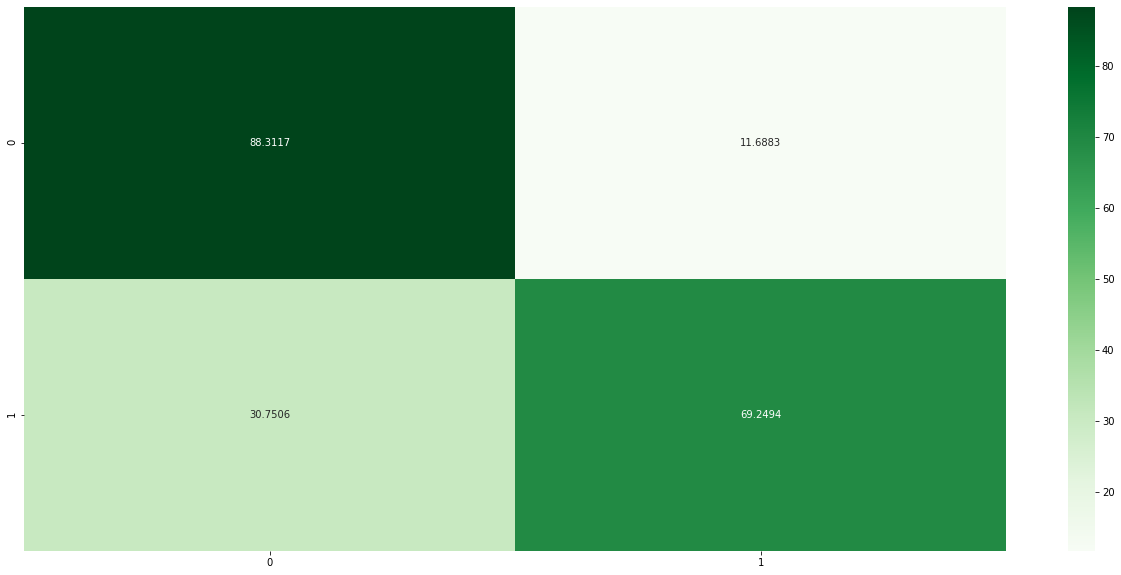

In [37]:
performance_plots(y_test, logistic_pred, 'Logistic Regression')

## SVM linear

In [30]:
svm_model = MyClassifier('LinSVC')
svm_model.fit(xtrain_count, y_train)
svm_pred = svm_model.predict(xtest_count)

---------LinSVC-----------
Accuracy:  0.7899159663865546
NORMALISED CM  for Tag6
              precision    recall  f1-score   support

           0       0.78      0.87      0.83      1084
           1       0.80      0.68      0.74       820

    accuracy                           0.79      1904
   macro avg       0.79      0.78      0.78      1904
weighted avg       0.79      0.79      0.79      1904

0.7899159663865546


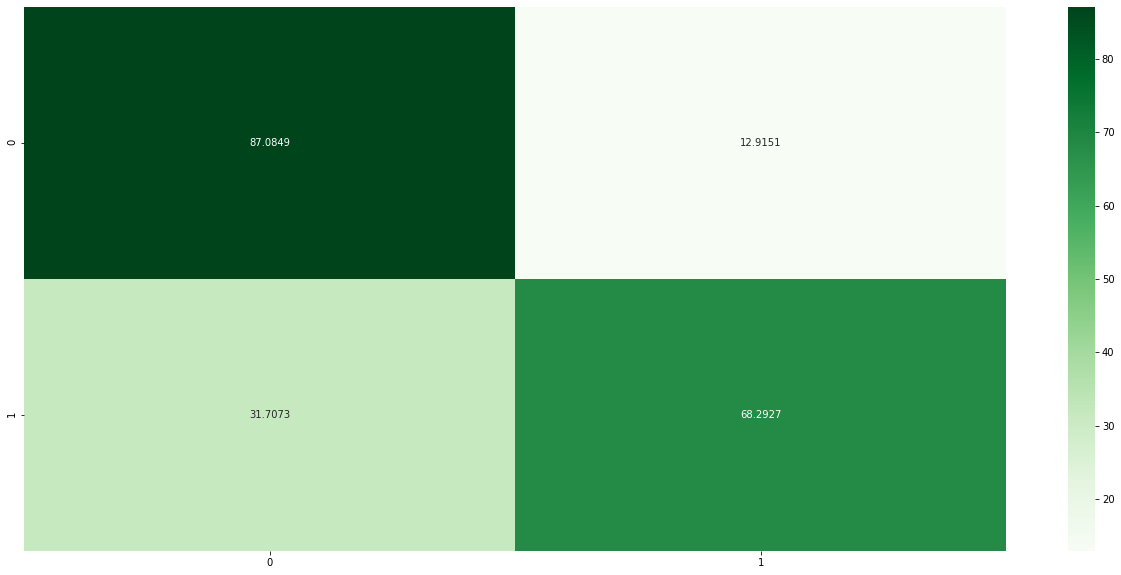

In [31]:
performance_plots(y_test, svm_pred, 'LinSVC')